##### What is this notebook about?

- We’ll create a document analysis system that:
    - Process images document
    - Extract text using vision models (Vision Language Model)
    - Perform calculations when needed (to demonstrate normal tools)
    - Analyze content and provide concise summaries
    - Execute specific instructions related to documents


In [1]:
import os
from typing import TypedDict, List, Dict, Any, Annotated, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, AnyMessage, SystemMessage
#from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

import base64
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from IPython.display import Image, display

### Setup AI model (LLM here)

In [2]:
# Set your OpenAI API key here
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
api_key = os.getenv('sk')
os.environ["OPENAI_API_KEY"] = api_key  # Replace with your actual API key

# Initialize LLM
# model = ChatOpenAI(model="gpt-4o-mini",temperature=0)

### Define state
-  To track all aspects of email processing

- AnyMessage is a class from Langchain that defines messages, and 
- add_messages is an operator that adds the latest message rather than overwriting it with the latest state. 
- This is a new concept in LangGraph, where you can add operators in your state to define the way they should interact together.

In [3]:
class AgentState(TypedDict):
    # The document provided
    input_file: Optional[str]  # Contains file path (PDF/PNG)
    messages: Annotated[list[AnyMessage], add_messages]

### Prepare tools

In [4]:
vision_llm = ChatOpenAI(model="gpt-4o")

def extract_text(img_path: str) -> str:
    """
    Extract text from an image file using a multimodal model.
    
    Master Wayne often leaves notes with his training regimen or meal plans.
    This allows me to properly analyze the contents.
    """
    all_text = ""
    try:
        # Read image and encode as base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()

        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        # Call the vision-capable model
        response = vision_llm.invoke(message)

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()
    except Exception as e:
        # A butler should handle errors gracefully
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""

def divide(a: int, b: int) -> float:
    """Divide a and b - for Master Wayne's occasional calculations."""
    return a / b

# Equip the butler with tools
tools = [
    divide,
    extract_text
]

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

### Define nodes 
- That interact with AI model (an LLM here)

In [5]:
def assistant(state: AgentState):
    # System message
    textual_description_of_tool="""
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
divide(a: int, b: int) -> float:
    Divide a and b
"""
    image=state["input_file"]
    sys_msg = SystemMessage(content=f"You are a helpful butler named Alfred that serves Mr. Wayne and Batman. You can analyse documents and run computations with provided tools:\n{textual_description_of_tool} \n You have access to some optional images. Currently the loaded image is: {image}")

    return {
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],
        "input_file": state["input_file"]
    }

### Define routing logic 

In [6]:
# None

### Create stategraph and add nodes/edges 

In [7]:
# The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")

In [8]:
# Compile the graph
react_graph = builder.compile()

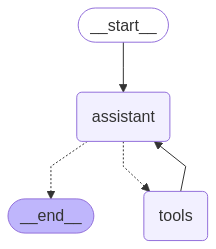

In [9]:
# View (# Show the butler's thought process)
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

### Run the application

In [10]:
messages = [HumanMessage(content="Divide 6790 by 5")]
messages = react_graph.invoke({"messages": messages, "input_file": None})

# Show the messages
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide 6790 by 5
================================== Ai Message ==================================
Tool Calls:
  divide (call_WH2YC95kYpeyAQfJrcfdVvrG)
 Call ID: call_WH2YC95kYpeyAQfJrcfdVvrG
  Args:
    a: 6790
    b: 5
================================= Tool Message =================================
Name: divide

1358.0
================================== Ai Message ==================================

The result of dividing 6790 by 5 is 1358.0.


In [ ]:
# Download image from https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Batman_training_and_meals.png to ./data/

messages = [HumanMessage(content="According to the note provided by Mr. Wayne in the provided images. What's the list of items I should buy for the dinner menu?")]
messages = react_graph.invoke({"messages": messages, "input_file": "./data/Batman_training_and_meals.png"})

# Show the messages
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

According to the note provided by Mr. Wayne in the provided images. What's the list of items I should buy for the dinner menu?
================================== Ai Message ==================================
Tool Calls:
  extract_text (call_uvhEd797HDdCiA8E3B08nIfY)
 Call ID: call_uvhEd797HDdCiA8E3B08nIfY
  Args:
    img_path: ./data/Batman_training_and_meals.png
================================= Tool Message =================================
Name: extract_text

```plaintext
TRAINING SCHEDULE
For the week of 2/20-2/26

SUNDAY 2/20
MORNING
30 minute jog
30 minute meditation
EVENING
clean and jerk lifts—3 reps/8 sets. 262 lbs.
5 sets metabolic conditioning:
   2 mile run
   12 kettlebell swings
   12 pull-ups
30 minutes flexibility
30 minutes sparring
MONDAY 2/21
MORNING
30 minute jog
30 minutes traditional kata (focus on Japanese forms)
EVENING
5 sets 20 foot rope climb
30 minutes gymnastics (work on muscl

### References:

> https://huggingface.co/learn/agents-course/  
> https://huggingface.co/learn/agents-course/unit2/langgraph/document_analysis_agent
